In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iminuit
from iminuit import Minuit, cost
from numba_stats import norm, truncexpon, crystalball, expon
from scipy.stats import argus
from scipy.optimize import curve_fit
import mplhep as hep
from numba import jit
hep.style.use("LHCb2")

np.random.seed(42)

In [2]:
BINS = 80

In [19]:
def fit_gaussian(x, mu, sigma, n):
    return n * norm.pdf(x, mu, sigma)

@jit
def minut_gaussian(x, mu, sigma, n):
    return n * norm.cdf(x, mu, sigma)

def cdf_crystal(x, beta, m, loc, scale, n):
    return crystalball.cdf(x, beta, m, loc, scale) *n

def fit_crystalball(x, beta, m, loc, scale, n):
    return n * crystalball.pdf(x, beta, m, loc, scale)

def minuit_argus(x, chi, loc, scale, norma):
    return argus.cdf(x, chi, loc, scale) * norma

In [7]:
data_minus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/j_psi/Bminus_muon.csv")
data_plus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/j_psi/Bplus_muon.csv")

data_minus = data_minus[data_minus > 3050]
data_plus = data_plus[data_plus > 3050]
data_plus = data_plus[data_plus < 3200]
data_minus = data_minus[data_minus < 3200]

In [8]:
n_plus, xe_plus = np.histogram(data_plus, bins=BINS)
cost_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus,
                                    minut_gaussian)

cost_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus,
                                    cdf_crystal)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [9]:
plus_minuit = Minuit(cost_plus, mu=+3100, sigma=20, n=10000)
plus_minuit_crystal = Minuit(cost_crystal_plus,
                              beta=1.2, m=1.2,
                              loc=3100, scale=20, n=100000)

In [10]:
plus_minuit.migrad()
plus_minuit.interactive()

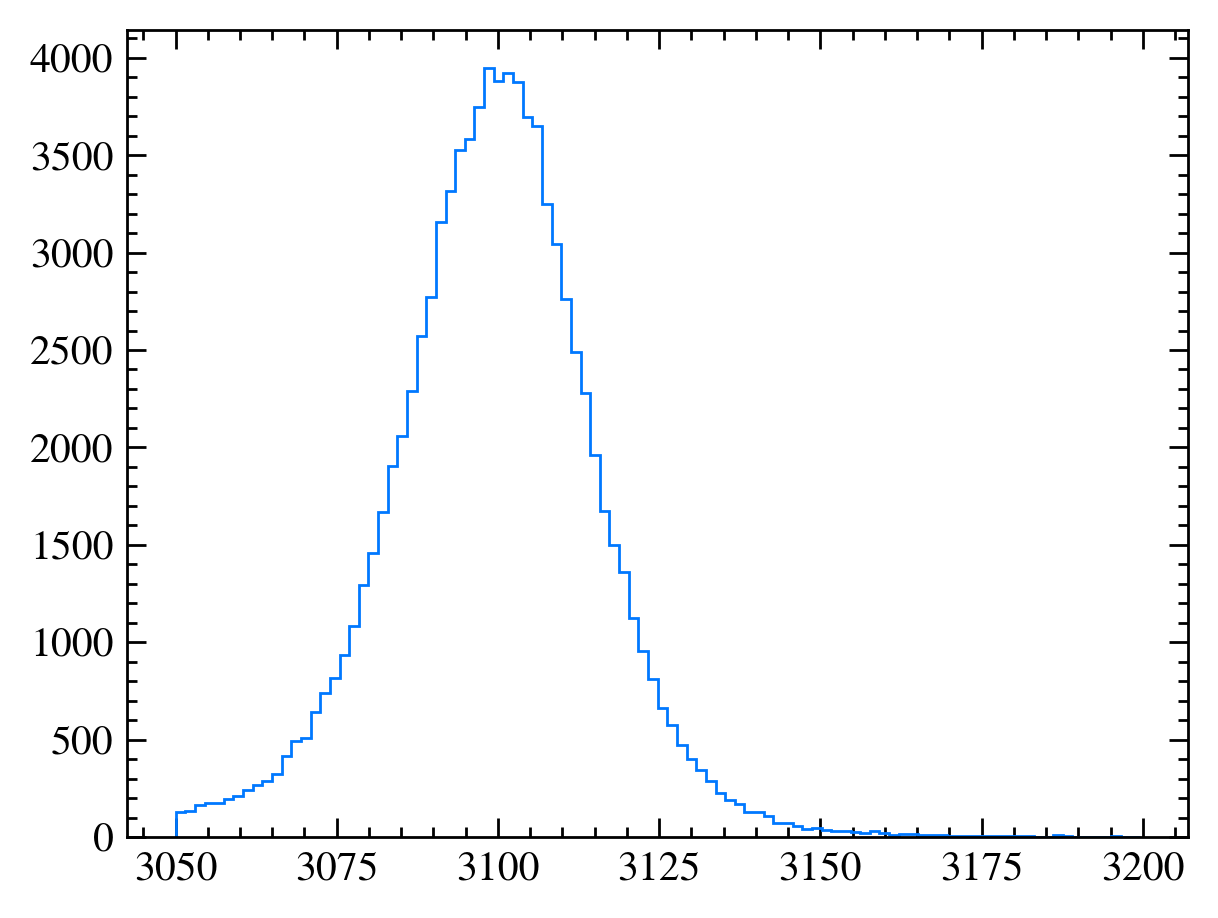

In [11]:
plt.hist(data_plus, bins=100, histtype="step", label="Data");

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3731 (χ²/ndof = 48.5)      │              Nfcn = 183              │
│ EDM = 2.69e-06 (Goal: 0.0002)    │            time = 1.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │ 3.09931e3 │ 0.00005e3 │            │            │         │         │       │
│ 1 │ sigma │   15.90   │   0.04    │            │            │         │         │       │
│ 2 │ n     │  91.91e3  │  0.30e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │       mu    sigma        n │
├───────┼────────────────────────────┤
│    mu │   0.0028  -0.0001  -0.0939 │
│ sigma │  -0.0001  0.00147   0.0069 │
│     n │  -0.0939   0.0069 9.29e+04 │
└───────┴────────────────────────────┘

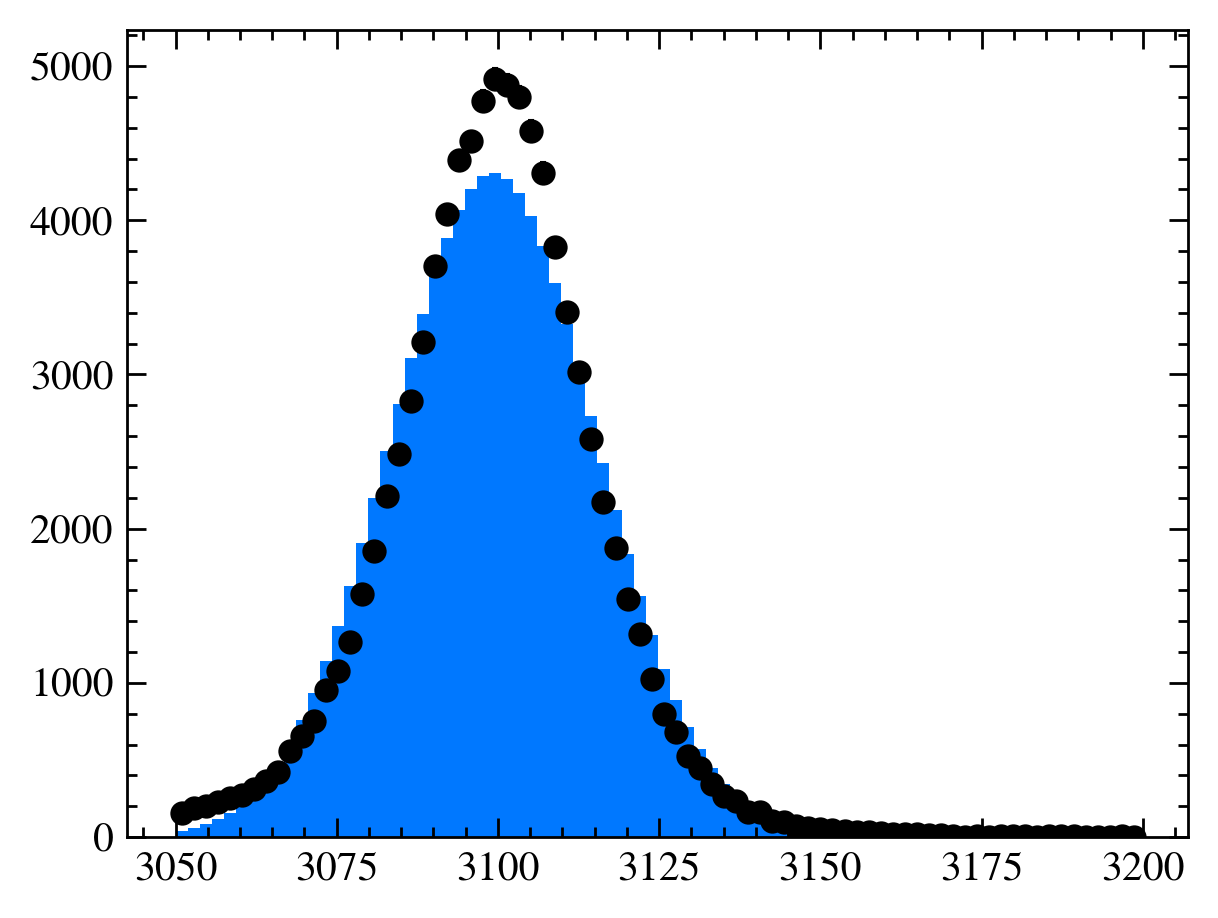

In [22]:
plus_minuit.hesse()

27.833414017957494
88901.6239096585
166205.3840287559


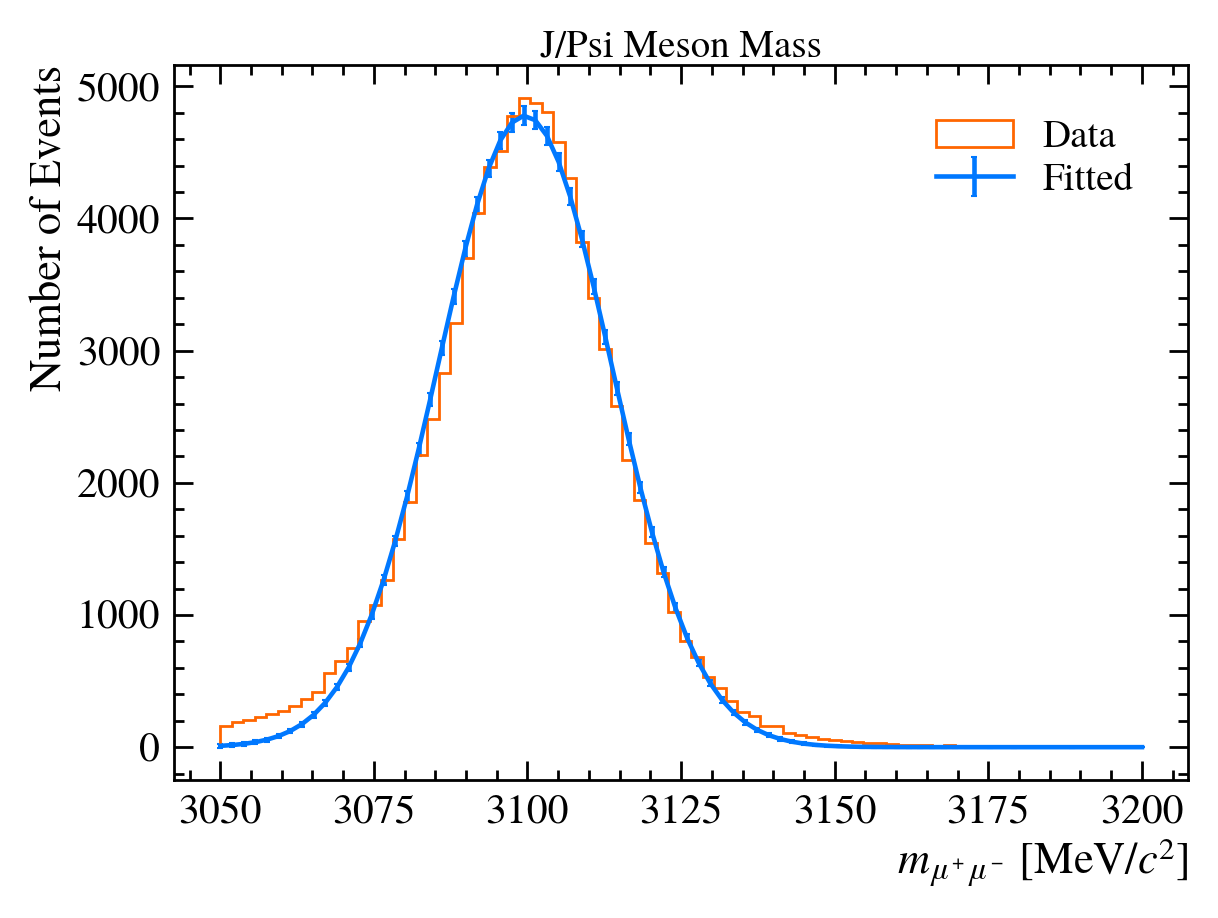

In [13]:
hist_raw = plt.hist(data_plus, bins=BINS, histtype="step", label="Data")
bin_centers = (hist_raw[1][:-1] + hist_raw[1][1:]) / 2
bin_heights = hist_raw[0]
plt.clf()

popt, pcov = curve_fit(fit_gaussian, bin_centers, bin_heights, p0=[3100, 10, 10000])
x = np.linspace(3050, 3200, BINS)
fitted_positive = norm.pdf(bin_centers, popt[0], popt[1]) * popt[2]

plt.errorbar(x, fitted_positive, label="Fitted",
             yerr=np.sqrt(bin_heights))
#plot data
plt.hist(data_plus, bins=BINS, histtype="step", label="Data")
#integrate to find the number of events
n_events_positive = np.trapz(fit_gaussian(bin_centers, *popt))

positive_bin_centers = bin_centers
positive_bin_heights = bin_heights
positive_model = fit_gaussian(bin_centers, *popt)

plt.title("J/Psi Meson Mass")
plt.xlabel("$m_{\mu^+ \mu^-}$ [MeV/$c^2$]")
plt.ylabel("Number of Events")

plt.legend()

chi_squared = np.sum((fitted_positive - bin_heights)**2 / bin_heights)
print((chi_squared / (len(bin_heights))))

#integrate to find the number of events
n_events_positive = np.trapz(fit_gaussian(bin_centers, *popt))
print(n_events_positive)
n_plus_norm = popt[-1]
print(n_plus_norm)


In [64]:
print(chi_squared / (len(bin_heights) - 3))

28.917832745929864


# Paper follow

In [29]:
from numba import jit
@jit
def signal(x, mu, sigma, n):
    return n * norm.cdf(x, mu, sigma)

from scipy.stats import halfnorm
def combinatorial(x, mu, sigma, n):
    result = n * norm.cdf(x, mu, sigma)
    return result
@jit
def background(x, tau, xoffset, norm):
    result = norm * expon.cdf(x, xoffset, tau)
    return result
    #return norm * truncexpon.cdf(x, x[0], x[-1], xoffset, tau)


@jit
def crystal_signal(x, beta, m, loc, scale, n):
    return n * crystalball.cdf(x, beta, m, loc, scale)
@jit
def cdf_crystal(x,
                crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm,
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, norm,
                total_norm):
    
    signal_result = crystal_signal(x, crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm)
    combinatorial_result = combinatorial(x, crystal_loc, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)



def fit_crystal(x, beta, m , loc, scale, c_norm, 
                comb_sigma, comb_n,
                tau, xoffset, exp_norm, total_norm
                ):
    crystal_val = crystalball.pdf(x, beta, m, loc, scale) * c_norm
    comb_val = norm.pdf(x, loc, comb_sigma) * comb_n
    exp_val = expon.pdf(x, tau, xoffset) * exp_norm
    return (crystal_val + comb_val + exp_val) * total_norm
def fit_curve_post_minut(data, p0_vals):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals)
    plt.clf()

    return popt, pcov


In [25]:
n_plus, xe_plus = np.histogram(data_plus, bins=BINS)

c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)
c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)


In [ ]:
n_plus_c = Minuit(     c_crystal_plus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=3100,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_plus_c.limits['crystal_m'] = (0, 20)
n_plus_c.limits['crystal_scale'] = (1, 100)
n_plus_c.limits['crystal_norm'] = (1, 1e4)
n_plus_c.limits['crystal_loc'] = (5280, 5310)

n_plus_c.limits['comb_mu'] = (5100, 5101)
n_plus_c.limits['comb_sigma'] = (1, 50)
n_plus_c.limits['comb_n'] = (1, 1e4)

n_plus_c.fixed["crystal_beta"] = True
n_plus_c.fixed["comb_mu"] = True


# FIT CRYSTAL

In [11]:
# plus_minuit_crystal.migrad()
plus_minuit_crystal.interactive()

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.49e+04 (χ²/ndof = 465.3) │              Nfcn = 69               │
│ EDM = 4.01e+04 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ beta  │   1.200   │   0.006   │            │            │         │         │       │
│ 1 │ m     │  1.2000   │  0.0015   │            │            │         │         │       │
│ 2 │ loc   │ 3.10000e3 │ 0.00008e3 │            │            │         │         │       │
│ 3 │ scale │   20.0    │    0.1    │            │            │         │         │       │
│ 4 │ n     │  100.0e3  │   0.4e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │        beta           m         loc       scale           n │
├───────┼─────────────────────────────────────────────────────────────┤
│  beta │    3.09e-05     -5.4e-6   -0.045e-3    0.059e-3 -865.388e-3 │
│     m │     -5.4e-6    2.33e-06      5.4e-6     -4.1e-6 -28.9735e-3 │
│   loc │   -0.045e-3      5.4e-6     0.00563      -0.002      -0.765 │
│ scale │    0.059e-3     -4.1e-6      -0.002      0.0107       3.582 │
│     n │ -865.388e-3 -28.9735e-3      -0.765       3.582     1.6e+05 │
└───────┴─────────────────────────────────────────────────────────────┘

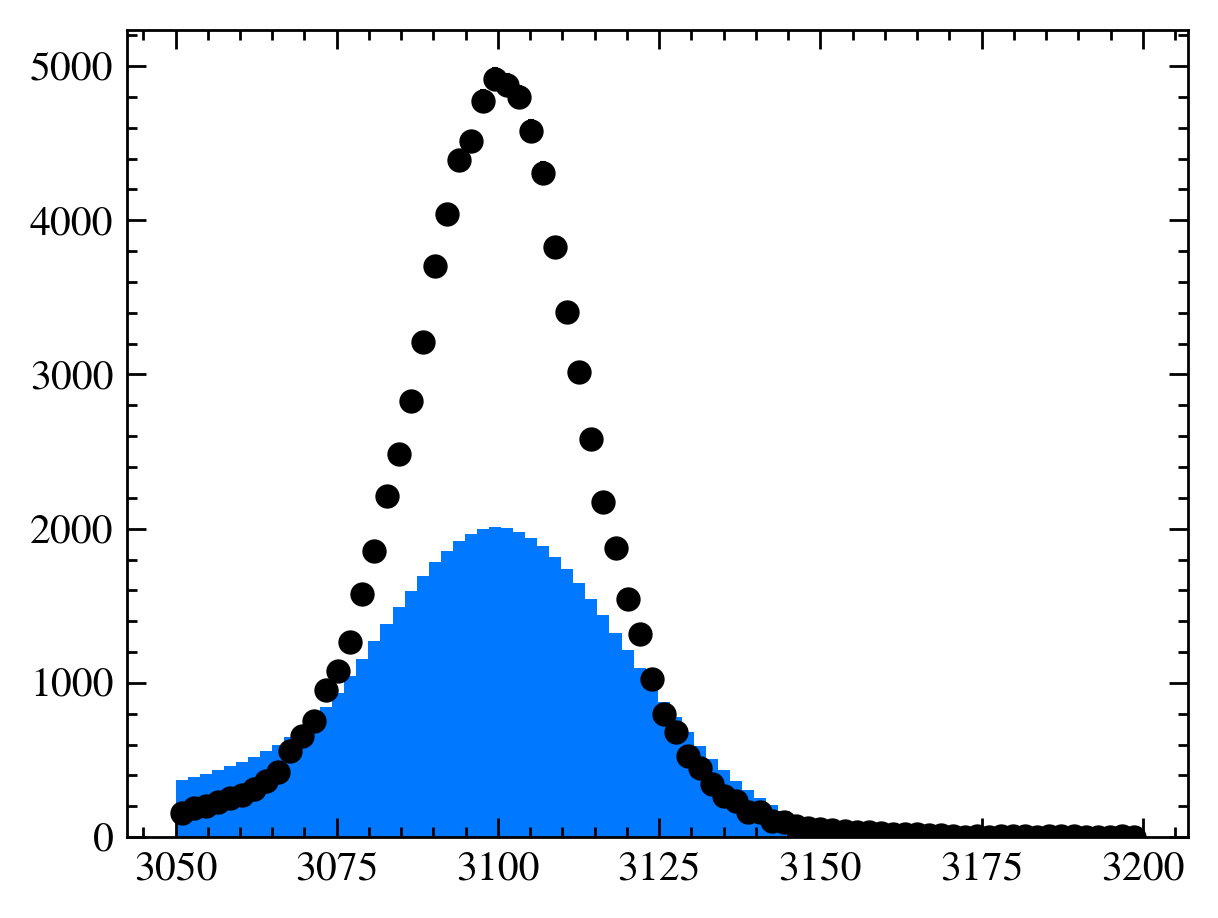

In [12]:
plus_minuit_crystal.hesse()

# Linear Background and Gaussian

153744.6562104463
22.72082044131779
82281.65411688262


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

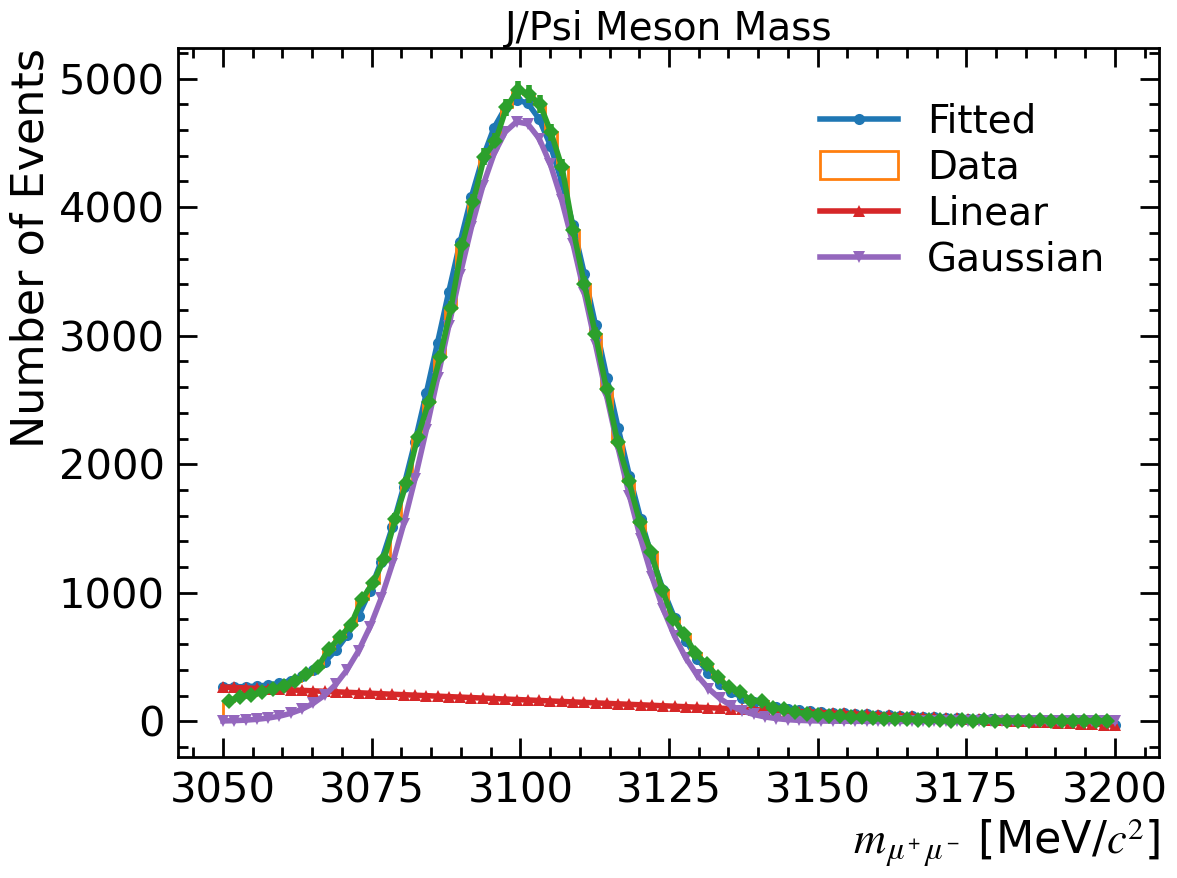

In [68]:
#fit linear and a gaussian
hist_raw = plt.hist(data_plus, bins=BINS, histtype="step", label="Data")
bin_centers = (hist_raw[1][:-1] + hist_raw[1][1:]) / 2
bin_heights = hist_raw[0]
plt.clf()

def fitting_func(x, mu, sigma, n, a, b):
    return fit_gaussian(x, mu, sigma, n) + a*x + b

#curve fit
popt, pcov = curve_fit(fitting_func, bin_centers, bin_heights, p0=[3100, 10, 10000, 0, 0])
fitted_positive = fitting_func(bin_centers, *popt)

signal = fitted_positive - popt[-2]*x - popt[-1]

plt.plot(x, fitted_positive, label="Fitted")
#plot data
plt.hist(data_plus, bins=BINS, histtype="step", label="Data")
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights))
#plot the linear part
plt.plot(x, popt[-2]*x + popt[-1], label="Linear")
#plot the gaussian part
plt.plot(x, fit_gaussian(x, *popt[:-2]), label="Gaussian")
#integrate to find the number of events


n_events_positive = np.trapz(signal)
norm_gaussian_positve = popt[2]
print(norm_gaussian_positve)
#print the chi-squared
chi_squared = np.sum((fitted_positive - bin_heights)**2 / bin_heights)
print((chi_squared / (len(bin_heights) - 5)))
print(n_events_positive)
plt.title("J/Psi Meson Mass")
plt.xlabel("$m_{\mu^+ \mu^-}$ [MeV/$c^2$]")
plt.ylabel("Number of Events")
plt.legend()



# J Minus

In [14]:
n_minus, xe_minus = np.histogram(data_minus, bins=BINS)
cost_minus = cost.ExtendedBinnedNLL(n_minus, xe_minus,
                                    minut_gaussian)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [15]:
minus_minuit = Minuit(cost_minus, mu=+3100, sigma=10, n=7000)
minus_minuit.limits["mu"] = (3070, 3130)
minus_minuit.limits["sigma"] = (0.1, 20 )

In [16]:
minus_minuit.migrad()
minus_minuit.interactive()

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

27.735639418558826
85415.89206039601
159877.89875270682


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

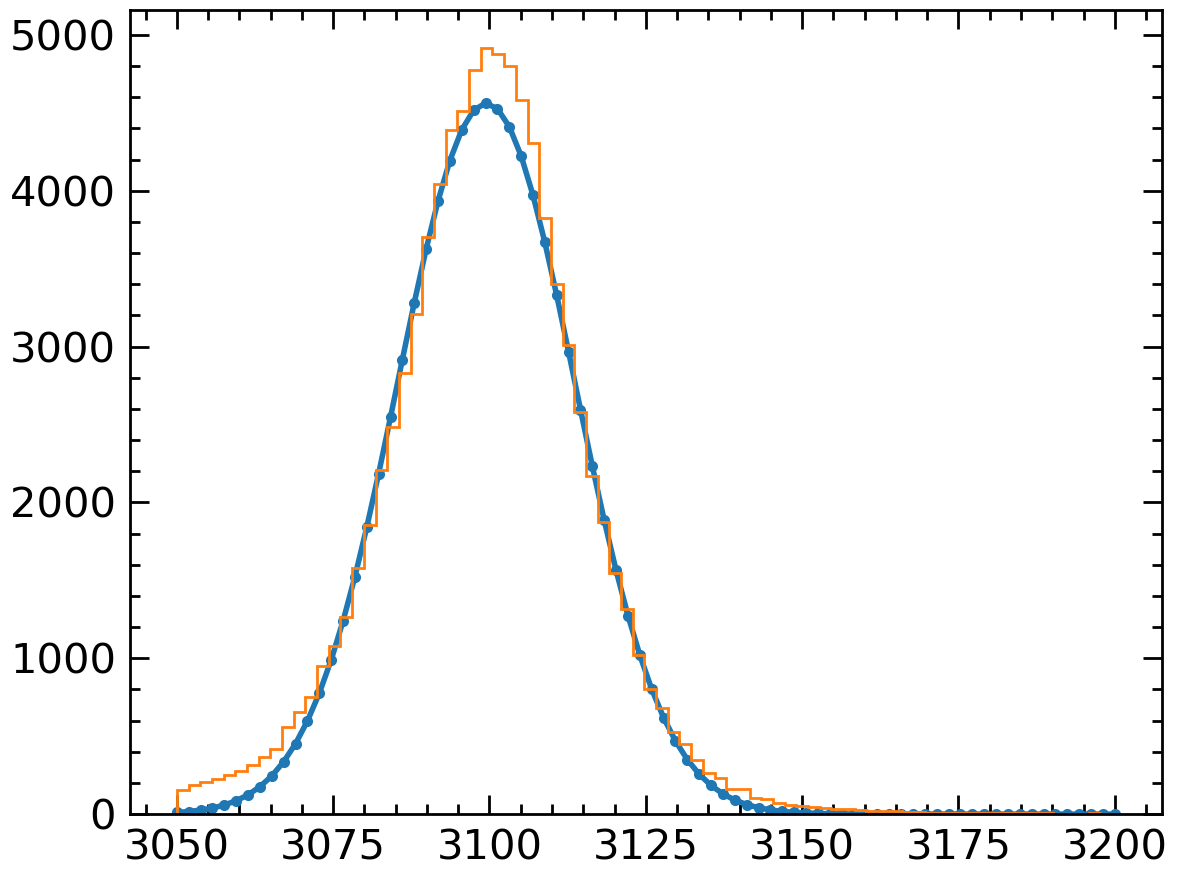

In [25]:
hist_raw = plt.hist(data_minus, bins=BINS, histtype="step", label="Data")
bin_centers = (hist_raw[1][:-1] + hist_raw[1][1:]) / 2
bin_heights = hist_raw[0]
plt.clf()

popt, pcov = curve_fit(fit_gaussian, bin_centers, bin_heights, p0=[3100, 16, 88000])
x = np.linspace(3050, 3200, BINS)
fitted_negative = norm.pdf(bin_centers, popt[0], popt[1]) * popt[2]

plt.plot(x, fitted_negative, label="Fitted")
#plot data
plt.hist(data_plus, bins=BINS, histtype="step", label="Data")
#integrate to find the number of events
n_events_negative = np.trapz(fit_gaussian(bin_centers, *popt))

negative_bin_centers = bin_centers
negative_bin_heights = bin_heights
negative_model = fit_gaussian(bin_centers, *popt)

chi_squared = np.sum((fitted_negative - bin_heights)**2 / bin_heights)
print((chi_squared / (len(bin_heights) - 3)))
negative_chi_squared = chi_squared / (len(bin_heights) - 3)
print(n_events_negative)
#print normalisation
n_minus_norm = popt[-1]
print(n_minus_norm)

16.45035646829892
79144.22746864443


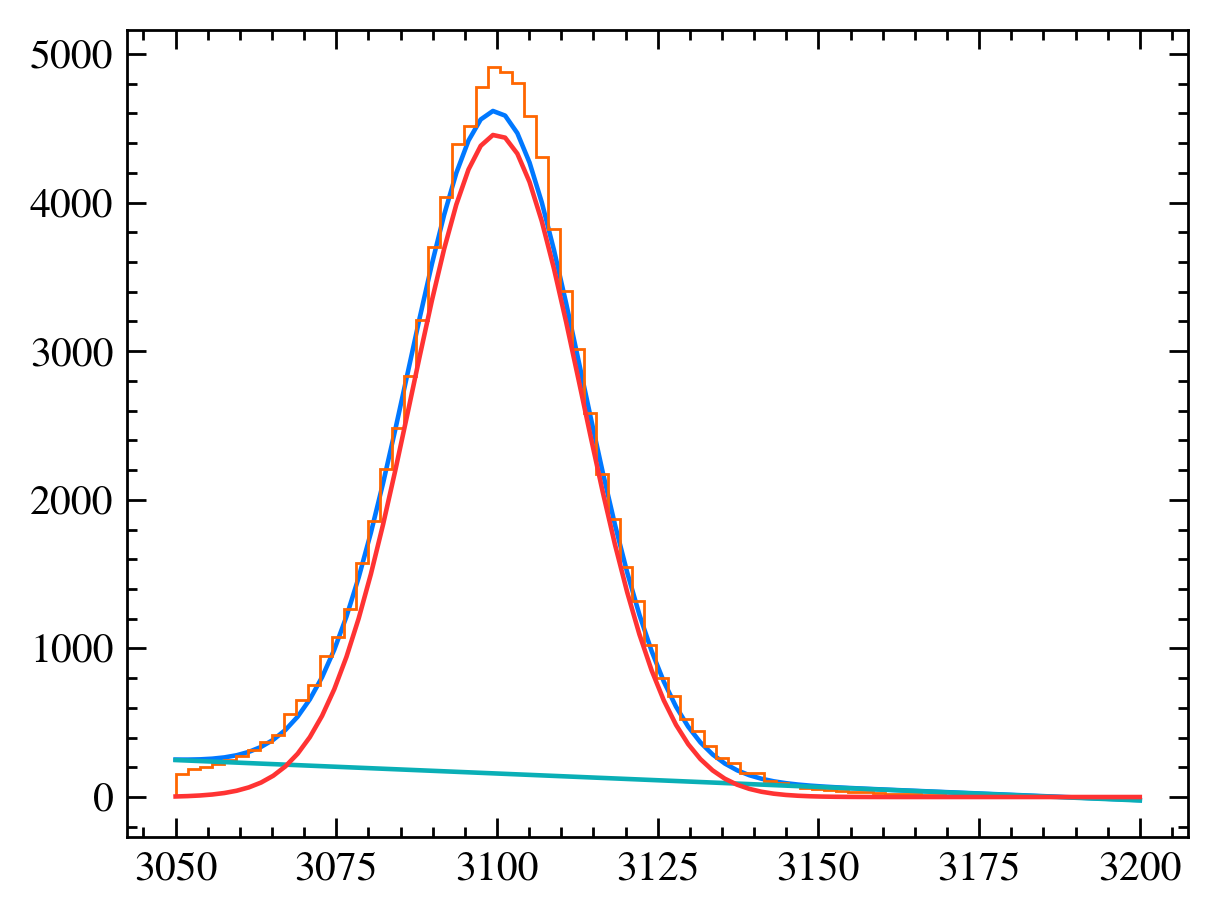

In [18]:
#fit linear and a gaussian
hist_raw = plt.hist(data_minus, bins=BINS, histtype="step", label="Data")
bin_centers = (hist_raw[1][:-1] + hist_raw[1][1:]) / 2
bin_heights = hist_raw[0]
plt.clf()

def fitting_func(x, mu, sigma, n, a, b):
    return fit_gaussian(x, mu, sigma, n) + a*x + b

#curve fit
popt, pcov = curve_fit(fitting_func, bin_centers, bin_heights, p0=[3100, 10, 10000, 0, 0])
x = np.linspace(3050, 3200, BINS)
fitted_positive = fitting_func(bin_centers, *popt)

plt.plot(x, fitted_positive, label="Fitted")
#plot data
plt.hist(data_plus, bins=BINS, histtype="step", label="Data")
#plot the linear part
plt.plot(x, popt[-2]*x + popt[-1], label="Linear")
#plot the gaussian part
plt.plot(x, fit_gaussian(x, *popt[:-2]), label="Gaussian")
#integrate to find the number of events
n_events_negative = np.trapz(fit_gaussian(bin_centers, *popt[:-2]))
#print the chi-squared
chi_squared = np.sum((fitted_positive - bin_heights)**2 / bin_heights)
print((chi_squared / (len(bin_heights) - 5)))
print(n_events_negative)




In [19]:
popt[2]

148118.7715116166

# Assymetric error

In [20]:
assymetry = (n_events_positive - n_events_negative) / (n_events_positive + n_events_negative)
print(assymetry)

unc_assymetry = np.sqrt((1 - assymetry**2)/ (n_events_positive + n_events_negative))
print(unc_assymetry)

0.019435710168792943
0.0024884640692899177


In [21]:
assymetry = -(n_plus_norm - n_minus_norm) / (n_plus_norm + n_minus_norm)
print(assymetry)
unc_assymetry = np.sqrt((1 - assymetry**2)/ (n_plus_norm + n_minus_norm))
print(unc_assymetry)

-0.019404506793712875
0.0017508702112251763


# JPSI PLOTTING


In [22]:
import mplhep as hep
hep.set_style("LHCb")

/tmp/ipykernel_85783/33942638.py:2: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("LHCb")
/home/aavash/anaconda3/lib/python3.10/site-packages/mplhep/_deprecate.py:107: FutureWarning: 'LHCb' style is deprecated as it may change in the future. Please use 'LHCb1' (which is the same as currently 'LHCb') or 'LHCb2'.
  warnings.warn(self.message, category=self._warning, stacklevel=1)


/tmp/ipykernel_85783/1503150729.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0)


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

<Figure size 2500x100 with 0 Axes>

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

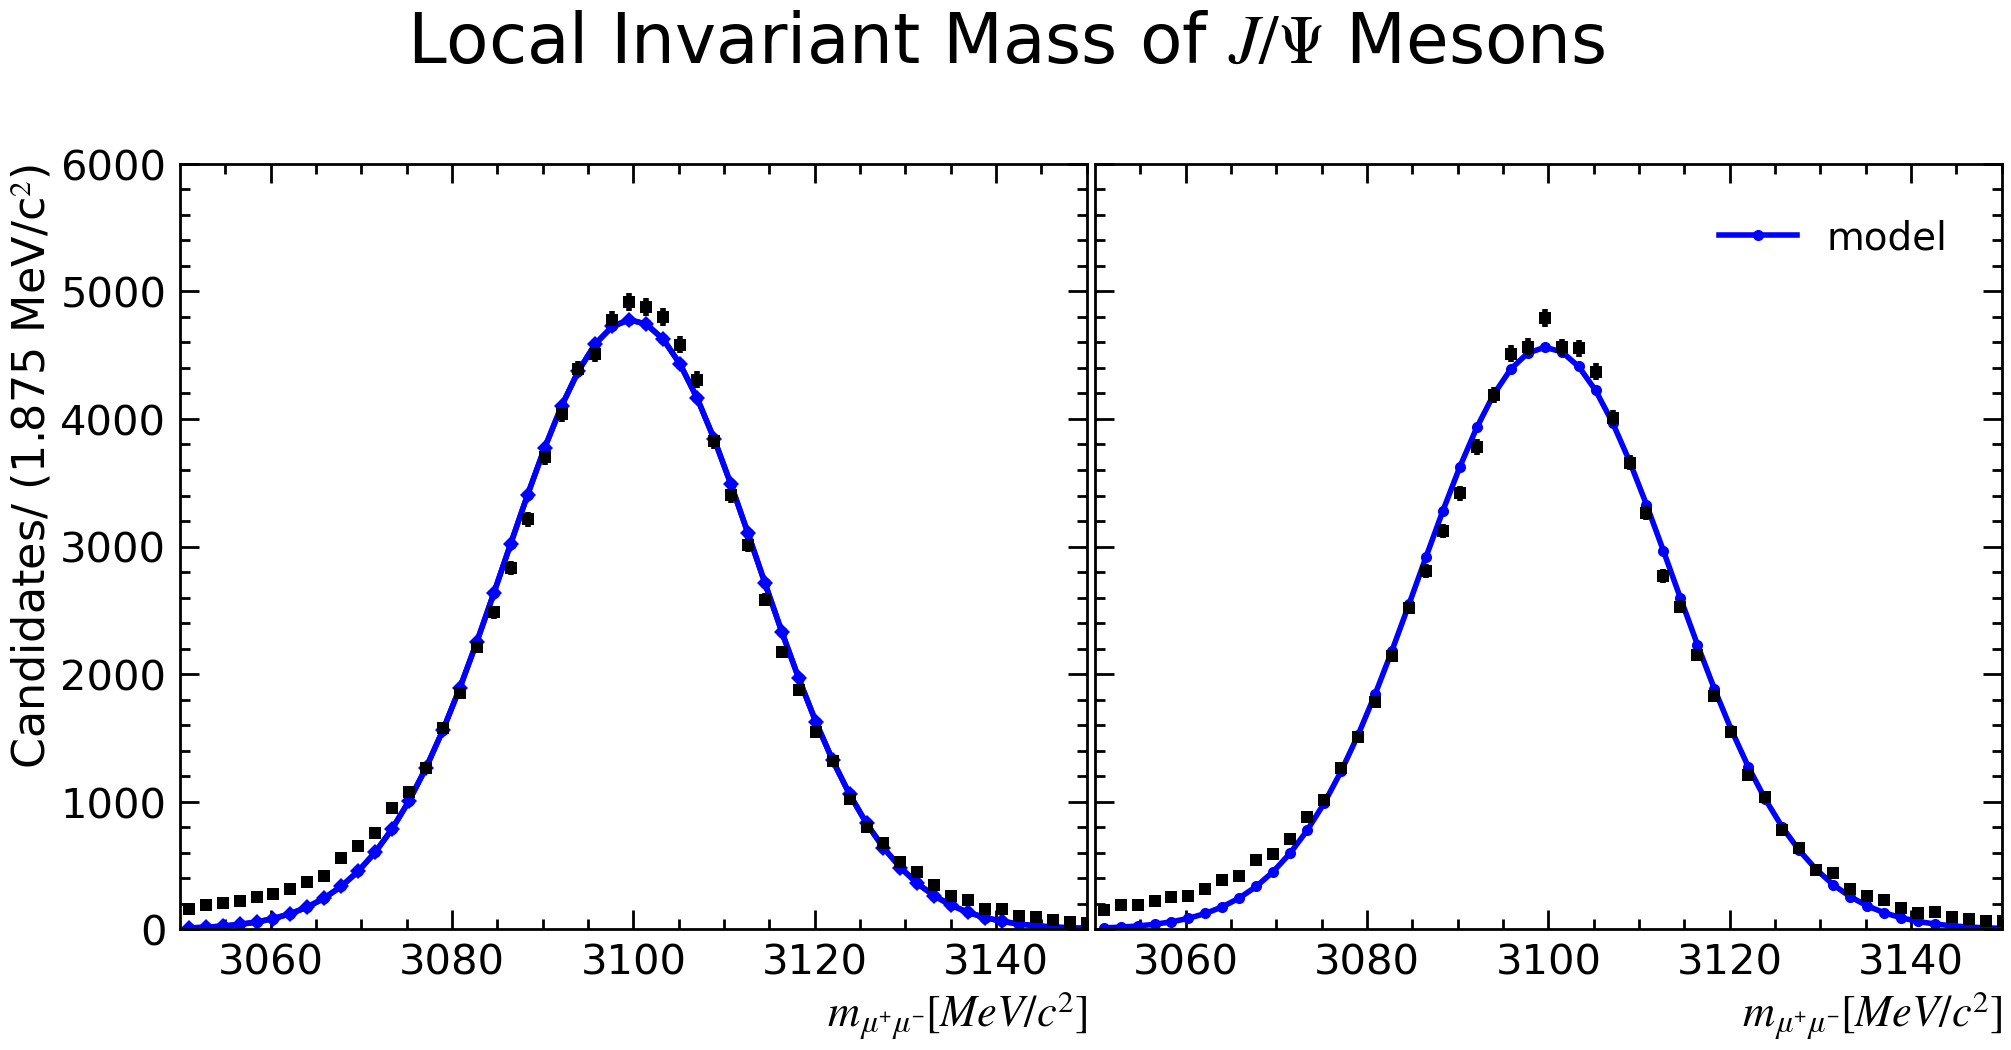

In [56]:
#plot the JPsi plus and minus 
#plot the fits side by side
#change the size of the plot
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(25, 1))
# use two axes to plot the data and the fit parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), sharey=True, constrained_layout=True,
                               gridspec_kw={'width_ratios': [1, 1],
                                            "wspace":0,
                                            })



#plot the positive results in ax1
ax1.plot(positive_bin_centers, positive_model, label="Model", color="blue")

#limit view to y > 0
ax1.set_ylim(bottom=0, top=6000)
#plot data with error bars
#make the gap between the two plots 0
ax1.errorbar(positive_bin_centers, positive_bin_heights, yerr=np.sqrt(positive_bin_heights),
                color="black",ls="None");
ax1.plot(positive_bin_centers, positive_model, label="model", color="blue");
#plot the negative results in ax2
ax2.plot(negative_bin_centers, negative_model, label="model", color="blue");

ax2.errorbar(negative_bin_centers, negative_bin_heights, yerr=np.sqrt(negative_bin_heights),
                color="black",ls="None")

#reduce the gap between the two axis to 0
plt.subplots_adjust(wspace=0)

#set the y-axis title for both plots
ax1.set_ylabel("Candidates/ (1.875 MeV/c$^2$)")
#set the y-label for both plots
ax1.set_xlabel(r"$m_{\mu^{+}\mu^{-}} [MeV/c^2]$")

ax2.set_xlabel(r"$m_{\mu^{+}\mu^{-}} [MeV/c^2]$")

#set a title of local invariant mass of B+ and B- and put in the middle
fig.suptitle("Local Invariant Mass of $J/ \Psi$ Mesons", fontsize=50, y=1.15)

#set the x-axis limits for both plots
ax1.set_xlim(3050, 3150)
ax2.set_xlim(3050, 3150)

ax2.legend(loc="upper right")
#plt.title("Local Invariant M

/tmp/ipykernel_85783/3873051761.py:10: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0)
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generi

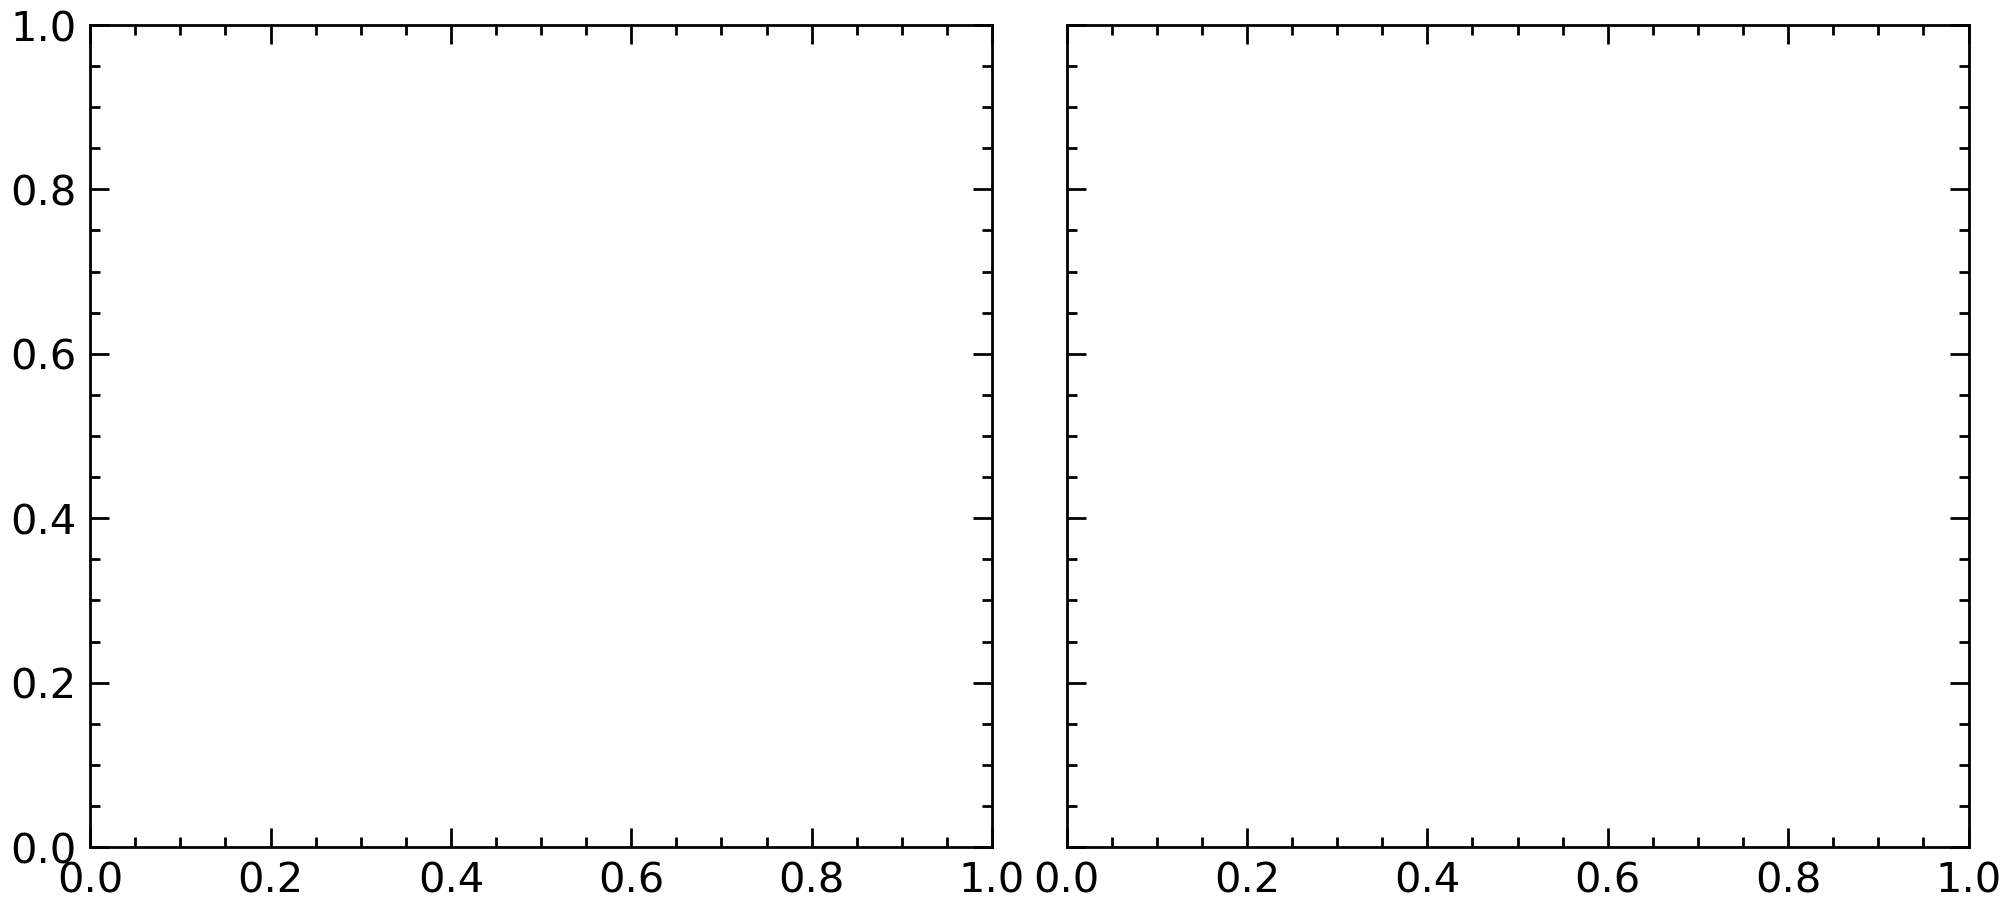

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

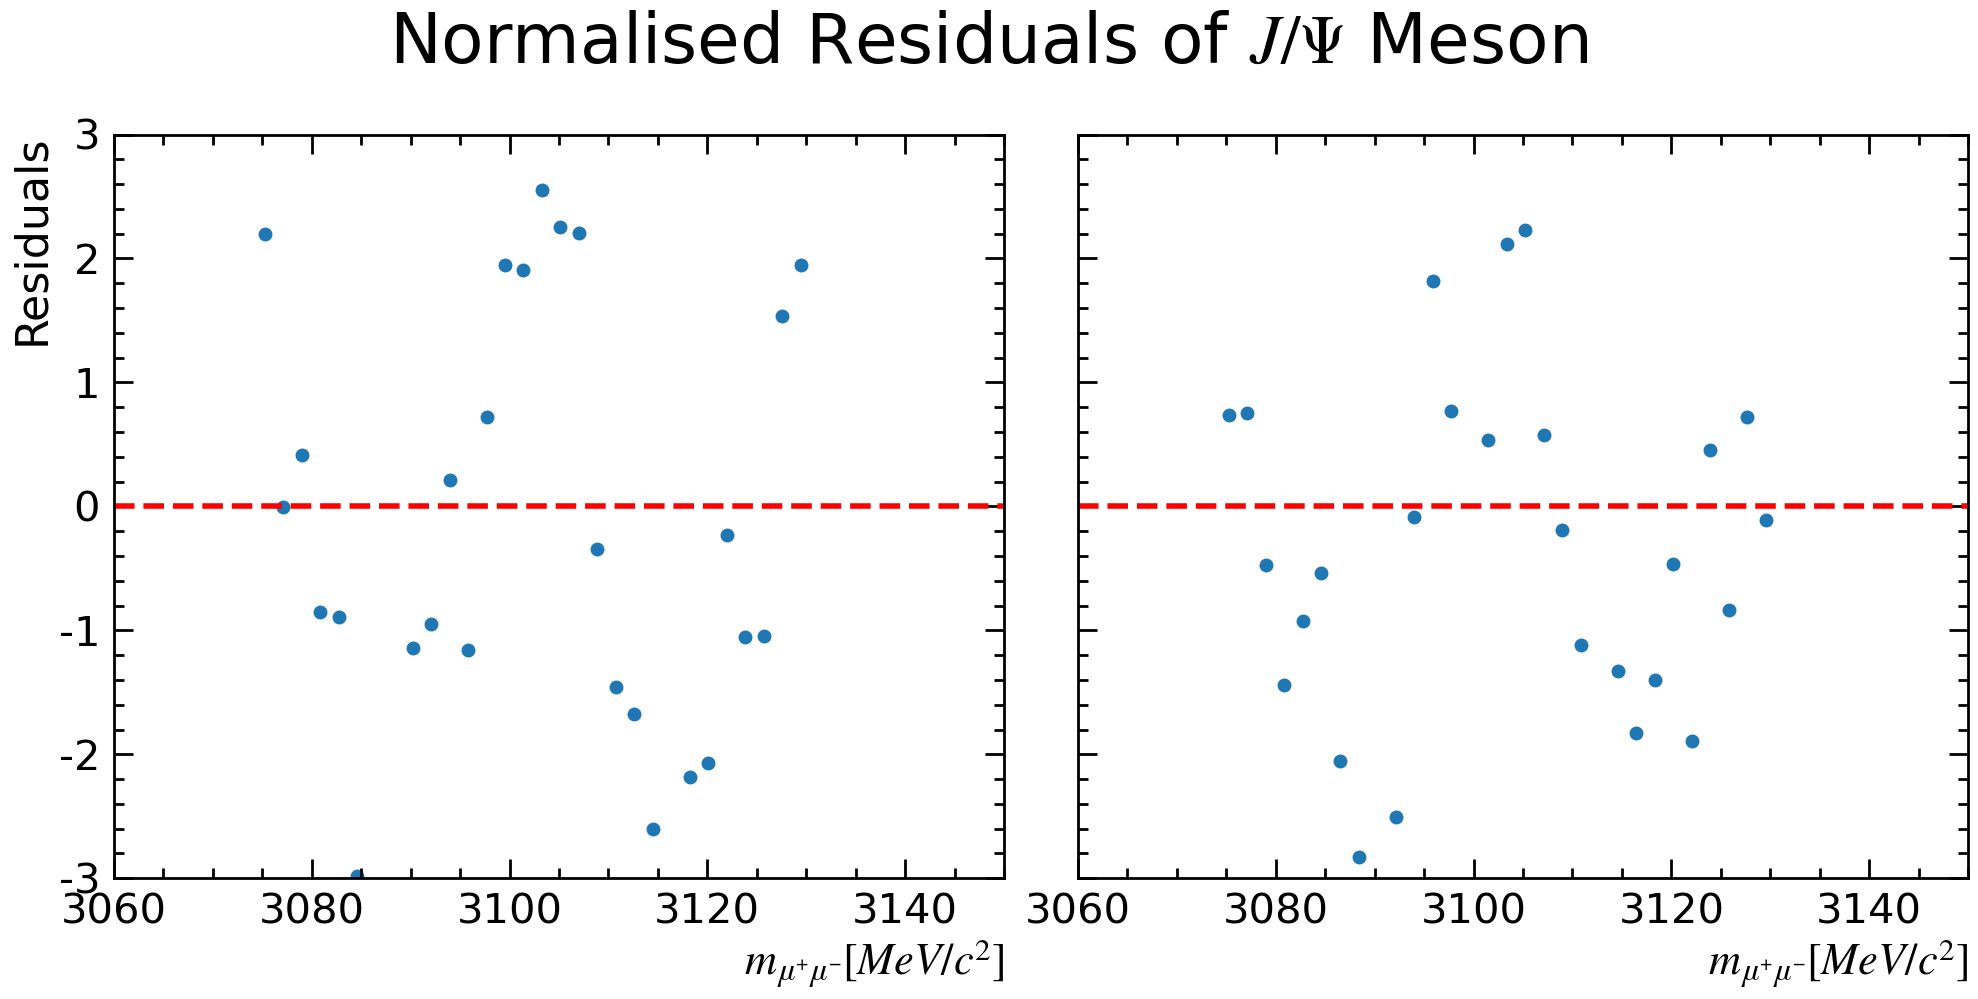

In [58]:
#PLOT THE RESIDU
#obtain the residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), sharey=True, constrained_layout=True,
                               gridspec_kw={'width_ratios': [1, 1],
                                            "wspace":0,
                                            })

positive_residuals = (positive_bin_heights - positive_model)/ np.sqrt(positive_bin_heights)
negative_residuals = (negative_bin_heights - negative_model) / np.sqrt(negative_bin_heights)
plt.subplots_adjust(wspace=0)

#plot the residuals in a new figure with them side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True);

#plot the residuals in ax1
ax1.scatter(positive_bin_centers, positive_residuals, 
                ls="None")
ax1.set_ylim(bottom=-100, top=100)
ax1.set_xlim(3060, 3150)
ax1.set_ylabel("Residuals")
ax1.axhline(0, color="red", ls="dashed")

#plot the residuals in ax2
ax2.scatter(negative_bin_centers, negative_residuals, 
                ls="None")
ax2.set_ylim(bottom=-3, top=3)
ax2.set_xlim(3060, 3150)
ax2.axhline(0, color="red", ls="dashed");

ax1.set_xlabel(r"$m_{\mu^{+}\mu^{-}} [MeV/c^2]$")

ax2.set_xlabel(r"$m_{\mu^{+}\mu^{-}} [MeV/c^2]$")

#set a title of residuals of B+ and B- and put in the middle
fig.suptitle("Normalised Residuals of $J/ \Psi$ Meson", fontsize=50, y=1);


Text(0.5, 1, 'Normalised Residuals of J/ $\\Psi$ Mesons')

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

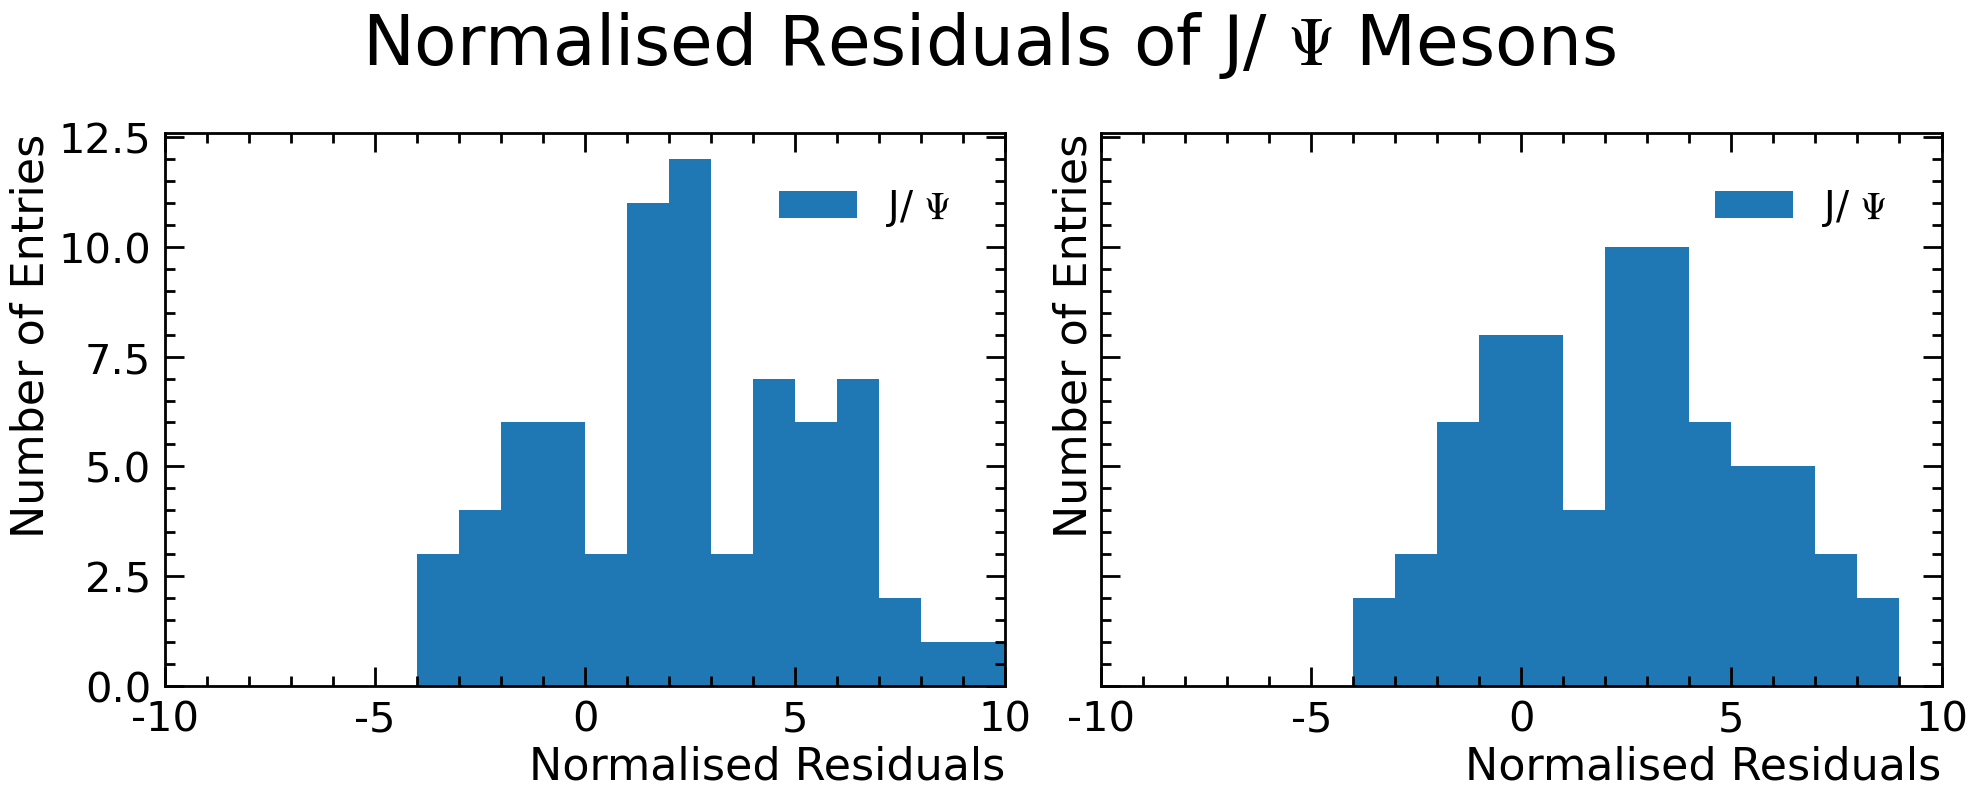

In [70]:
#plot a histogram of the residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

#plot the normalised residuals in ax1
ax1.hist(positive_residuals, bins=20, range=(-10, 10), label="J/ $\Psi$")
ax1.set_xlabel("Normalised Residuals")
ax1.set_ylabel("Number of Entries")
ax1.set_xlim(-10, 10)
ax1.legend(loc="upper right")
#plot the normalised residuals in ax2
ax2.hist(negative_residuals, bins=20, range=(-10, 10), label="J/ $\Psi$")
ax2.set_xlabel("Normalised Residuals")
ax2.set_ylabel("Number of Entries")
ax2.set_xlim(-10, 10)
ax2.legend(loc="upper right")

#set a title of normalised residuals of B+ and B- and put in the middle
fig.suptitle("Normalised Residuals of J/ $\Psi$ Mesons", fontsize=50, y=1)
#set the super y label